In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn   as nn

# feature extraction stuff
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models.detection.backbone_utils import LastLevelMaxPool

# jupyter stuff
from IPython.display     import display, clear_output

In [2]:
# colab drive access

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load image

true_object_np = plt.imread('drive/MyDrive/Colab Notebooks/webb-jupiter-small.jpg') # load from drive
true_object_np = 0.1*true_object_np[:,:,0] # only use red channel

In [9]:
# convert image betwen numpy and pytorch formats

def np_to_torch(np_array):      return torch.from_numpy(np_array).float()
def torch_to_np(torch_array):   return np.squeeze(torch_array.detach().cpu().numpy())

In [ ]:
# detect gpu/cuda, run there if possible

device         = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# make image noisy

true_object_torch    = np_to_torch(true_object_np).to(device)
noisy_image_torch    = torch.poisson(true_object_torch)
noisier_image_torch  = torch.poisson(torch.poisson(noisy_image_torch))

fig1, axs1 = plt.subplots(1,3, figsize=(12,4)) # No. rows, cols,  figsize Width,Height (inches)
axs1[0].imshow(torch_to_np(true_object_torch),cmap='Greys_r'); axs1[0].set_title('True'); axs1[0].set_axis_off();
axs1[1].imshow(torch_to_np(noisy_image_torch), vmin=0,vmax=np.max(true_object_np),cmap='Greys_r'); axs1[1].set_title('Noisy'); axs1[1].set_axis_off();
axs1[2].imshow(torch_to_np(noisier_image_torch), vmin=0,vmax=np.max(true_object_np),cmap='Greys_r'); axs1[2].set_title('Noisier'); axs1[2].set_axis_off();

In [5]:
# Convolutional neural network with feature extraction

class CNN_FPN(nn.Module):
    def __init__(self, num_channels):
        super(CNN_FPN, self).__init__()

        # number of convolutional kernels per layer
        self.channels = num_channels

        # CNN backbone
        model = nn.Sequential(
            nn.Conv2d(1,            self.channels, 3, padding=1), nn.PReLU(),
#             nn.Conv2d(self.channels, self.channels, 3, padding=1), nn.PReLU(),
#             nn.Conv2d(self.channels, self.channels, 3, padding=1), nn.PReLU(),
            nn.Conv2d(self.channels, 1,            3, padding=1), nn.PReLU()
        )

        # get the names of the node layers
        train_nodes, eval_nodes = get_graph_node_names(model)
        self.lastlayer = f'layer{len(train_nodes)}' # name of last layer
        self.layers = { name: f'layer{i+1}' for i, name in enumerate(train_nodes) } # dictionary of layers for FPN
        print(self.layers)

        # add feature extraction middleman
        self.CNN = create_feature_extractor(model, return_nodes=self.layers)

        # dry run to get number of channels for FPN
        with torch.no_grad():
            out = self.CNN(noisy_image_torch.unsqueeze(0).unsqueeze(0))

        in_channels_list = [o.shape[1] for o in out.values()]
        print(in_channels_list)

        # build FPN
        self.FPN = FeaturePyramidNetwork(
            in_channels_list, out_channels=self.channels,
            extra_blocks=LastLevelMaxPool())

    def forward(self, x):

        # cnn output
        out_cnn = self.CNN(x.unsqueeze(0).unsqueeze(0))

        # fpn output
        out_fpn = self.FPN(out_cnn)

        return out_cnn, out_fpn

cnn_fpn = CNN_FPN(3).to(device)

model nodes:  ['input', '0', '1', '2', '3']
[1, 3, 3, 1, 1]


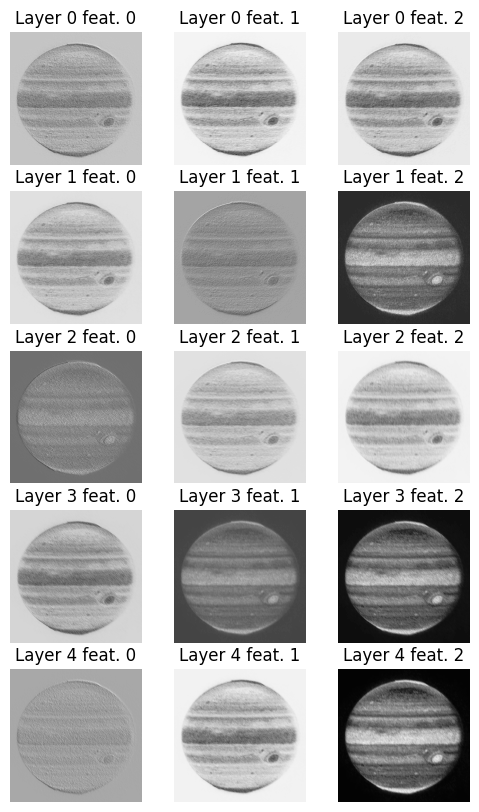

In [6]:
# display the features extracted from the layers

def display_features():
  output_cnn, out_fpn = cnn_fpn(noisy_image_torch)
  fig1, axs1 = plt.subplots(len(cnn_fpn.layers),cnn_fpn.channels, figsize=(2*cnn_fpn.channels, 2*len(cnn_fpn.layers)))

  # loop over layers
  for i, node in enumerate(cnn_fpn.layers.values()):
      layer = torch_to_np(out_fpn[node])

      # loop over features in each layer
      for j, feature in enumerate(layer):
        if j==cnn_fpn.channels: break # don't overflow

        axs1[i,j].imshow(feature, cmap='Greys_r')
        axs1[i,j].set_title(f"Layer {i} feat. {j}")
        axs1[i,j].set_axis_off()

display_features()

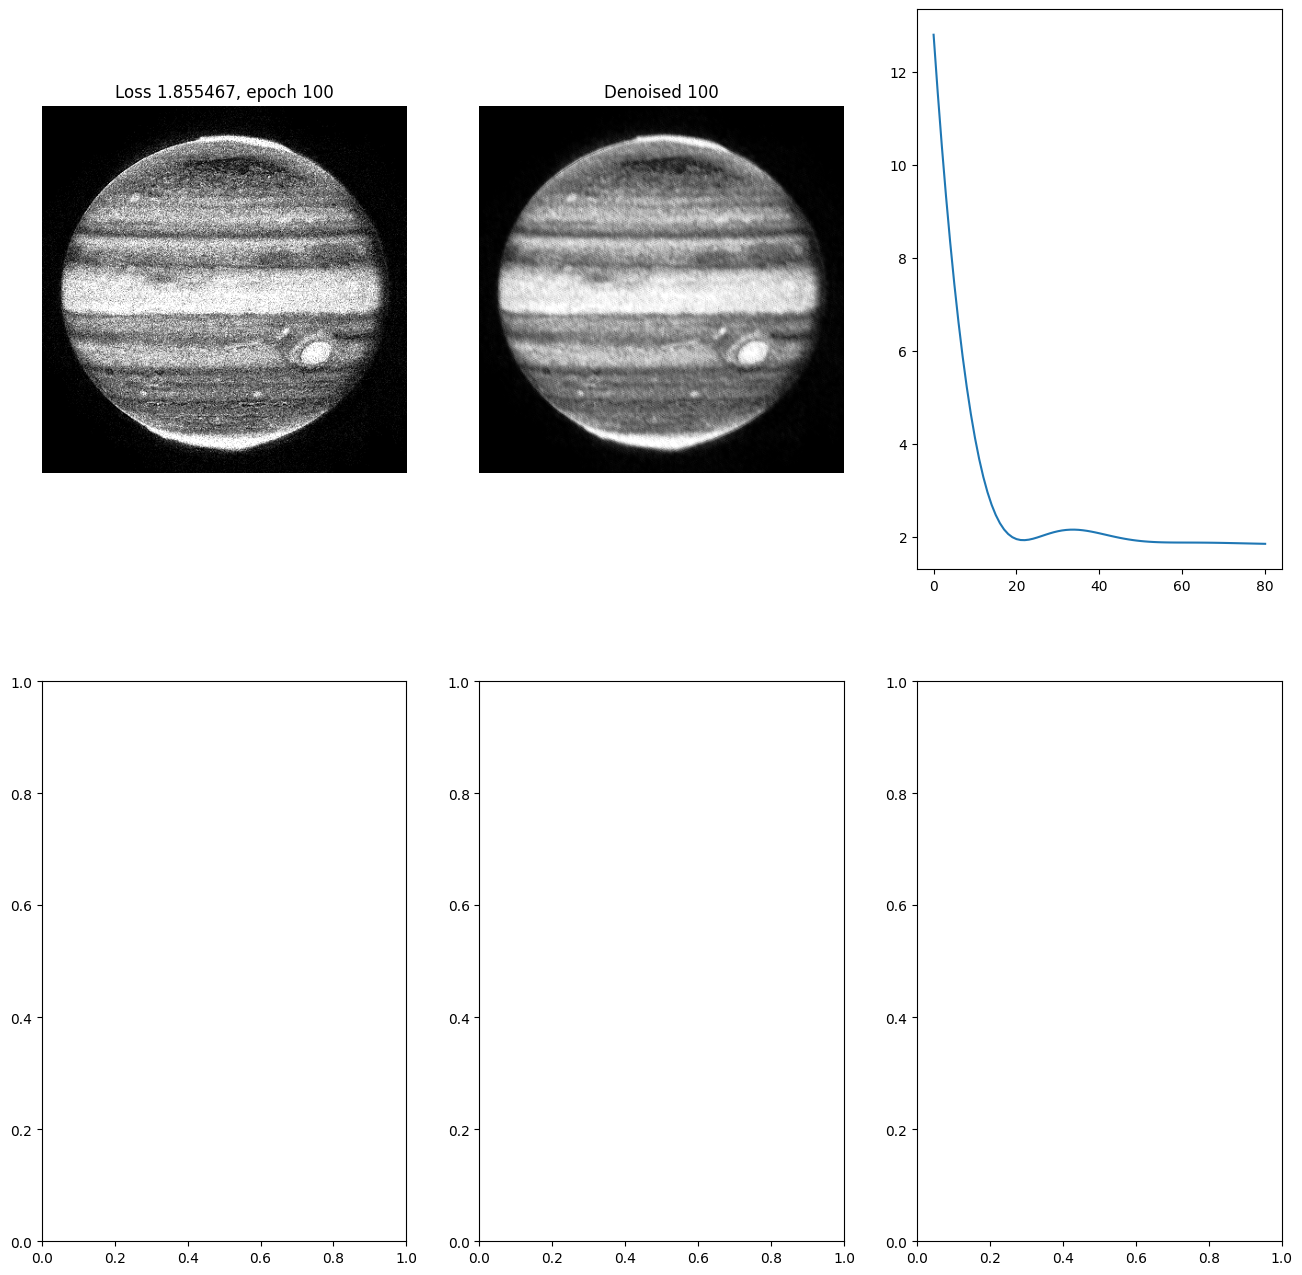

In [7]:
#===============================================TRAIN THE NETWORK
loss_fun  = nn.MSELoss()
optimiser = torch.optim.Adam(cnn_fpn.parameters(), lr=1e-3)

train_loss = list()
epochs     = 101

for ep in range(epochs):
    optimiser.zero_grad() # set the gradients to zero
    out_cnn, out_fpn = cnn_fpn(noisy_image_torch)
    loss = loss_fun(torch.squeeze(out_cnn[cnn_fpn.lastlayer]), torch.squeeze(true_object_torch))

    denoised_result = out_cnn[cnn_fpn.lastlayer]

    train_loss.append(loss.item())
    loss.backward() # Find the gradients
    optimiser.step() # Does the update

    if ep % 20 == 0:
        fig2, axs2 = plt.subplots(2,3, figsize=(16,16)) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].set_axis_off(); axs2[0,1].set_axis_off()
        axs2[0,0].imshow(torch_to_np(noisy_image_torch), vmin=0,vmax=np.max(true_object_np),cmap='Greys_r'); axs2[0,0].set_title('Noisy Input %d x %d' % (true_object_np.shape[0],true_object_np.shape[1]))
        axs2[0,1].imshow(torch_to_np(denoised_result), vmin=0,vmax=np.max(true_object_np), cmap='Greys_r'); axs2[0,1].set_title('Denoised %d' % (ep))
        axs2[0,2].plot(train_loss[19:-1]);  axs2[0,0].set_title('Loss %f, epoch %d' % (train_loss[-1],ep));
        clear_output(wait=True); plt.pause(0.001)

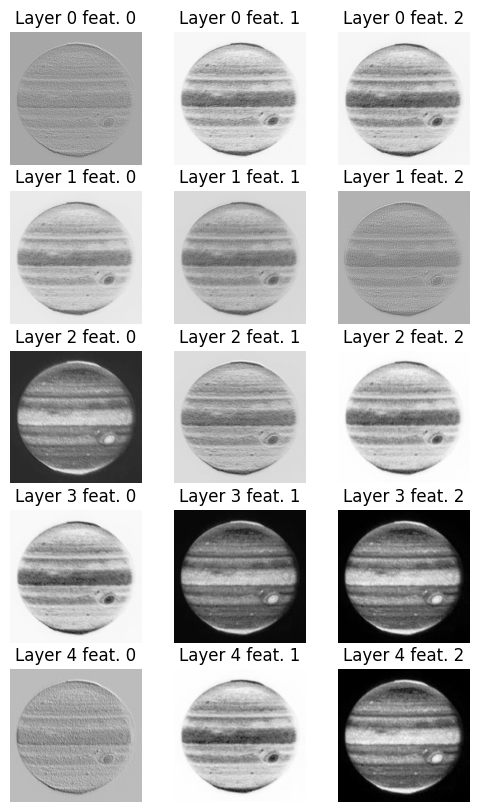

In [8]:
display_features()